../../../../data/all_checkpoints/benchmark_1049inputs_20250726_011032fixedseedfixedrbf-checkpoint_20250726_022118.pt
{'runid': '20250726_011032fixedseedfixedrbf', 'num_nbrs': 100, 'num_nbrs_egnn': 11, 'learning_rate': [0.005], 'dataset': ('1000inputs/*.npz', 749, 300), 'epochs': 1000, 'dim': 6, 'depth': 2, 'basis': 8, 'hidden_dim': 4, 'num_heads': 14, 'dropout': [0.04, 0.03], 'rbf cutoff': 20.0, 'loss': MSELoss(), 'params': 14976}
../../../../data/pkegnn_INS/inputs/4ll7.npz
[b'103A4' b'103B4' b'103C4' b'103D4' b'103E4' b'103F4' b'103G4' b'103H4'
 b'105A2' b'105B2' b'105C2' b'105D2' b'105E2' b'105F2' b'105G2' b'105H2'
 b'107A2' b'107B2' b'107C2' b'107D2' b'107E2' b'107F2' b'107G2' b'107H2'
 b'108A2' b'108B2' b'108C2' b'108D2' b'108E2' b'108F2' b'108G2' b'108H2'
 b'110A2' b'110B2' b'110C2' b'110D2' b'110E2' b'110F2' b'110G2' b'110H2'
 b'111A4' b'111B4' b'111C4' b'111D4' b'111E4' b'111F4' b'111G4' b'111H4'
 b'113A4' b'113B4' b'113C4' b'113D4' b'113E4' b'113F4' b'113G4' b'113H4'
 b'114A2' 

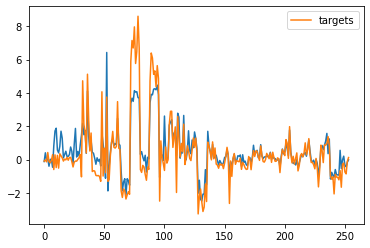

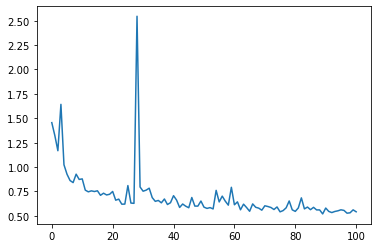

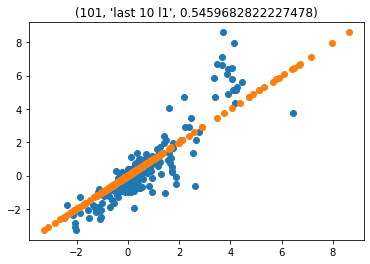

tensor(0.5830)
tensor(0.8769)
tensor(0.3049)


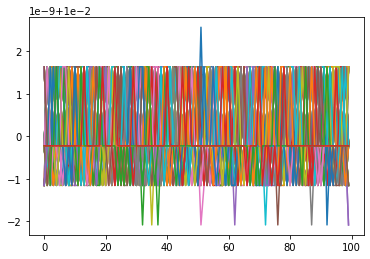

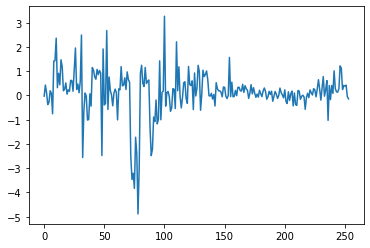

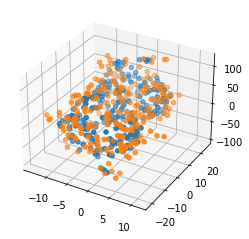

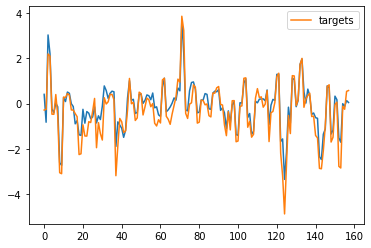

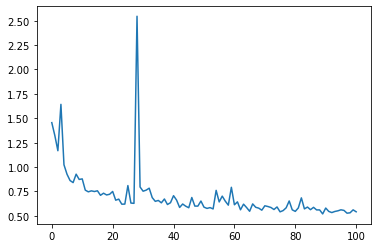

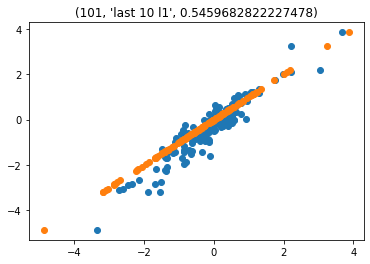

tensor(0.3604)
tensor(0.2342)
tensor(0.1136)


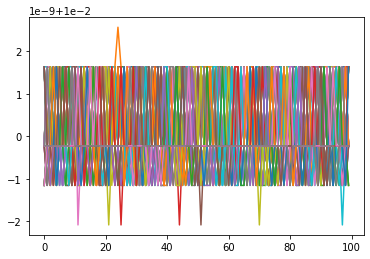

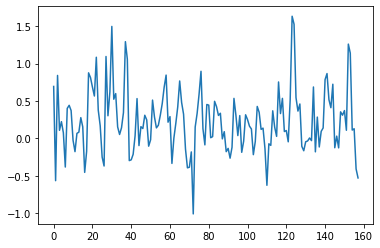

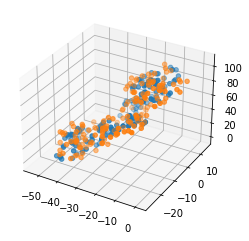

../../../../data/all_checkpoints/benchmark_1049inputs_20250726_011032fixedseedfixedrbf-checkpoint_20250726_033059.pt
{'runid': '20250726_011032fixedseedfixedrbf', 'num_nbrs': 100, 'num_nbrs_egnn': 11, 'learning_rate': [0.005], 'dataset': ('1000inputs/*.npz', 749, 300), 'epochs': 1000, 'dim': 6, 'depth': 2, 'basis': 8, 'hidden_dim': 4, 'num_heads': 14, 'dropout': [0.04, 0.03], 'rbf cutoff': 20.0, 'loss': MSELoss(), 'params': 14976}
../../../../data/pkegnn_INS/inputs/4ll7.npz
[b'103A4' b'103B4' b'103C4' b'103D4' b'103E4' b'103F4' b'103G4' b'103H4'
 b'105A2' b'105B2' b'105C2' b'105D2' b'105E2' b'105F2' b'105G2' b'105H2'
 b'107A2' b'107B2' b'107C2' b'107D2' b'107E2' b'107F2' b'107G2' b'107H2'
 b'108A2' b'108B2' b'108C2' b'108D2' b'108E2' b'108F2' b'108G2' b'108H2'
 b'110A2' b'110B2' b'110C2' b'110D2' b'110E2' b'110F2' b'110G2' b'110H2'
 b'111A4' b'111B4' b'111C4' b'111D4' b'111E4' b'111F4' b'111G4' b'111H4'
 b'113A4' b'113B4' b'113C4' b'113D4' b'113E4' b'113F4' b'113G4' b'113H4'
 b'114A2' 

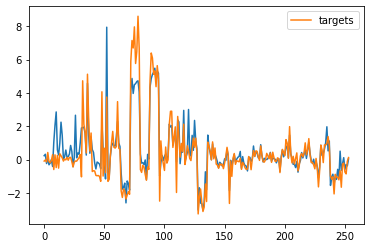

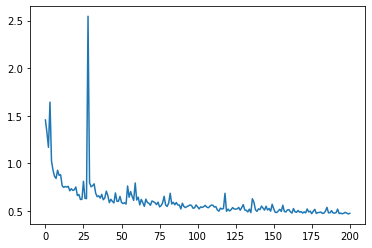

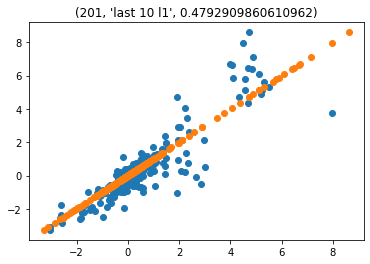

tensor(0.5069)
tensor(0.7292)
tensor(0.2545)


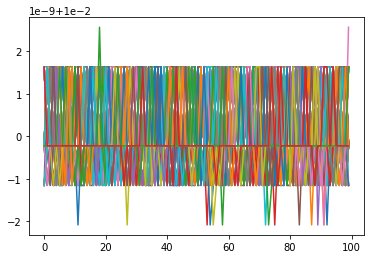

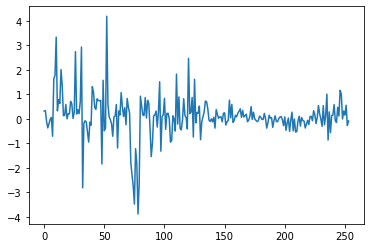

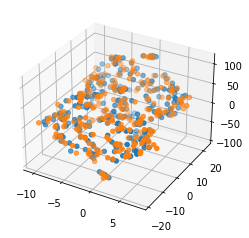

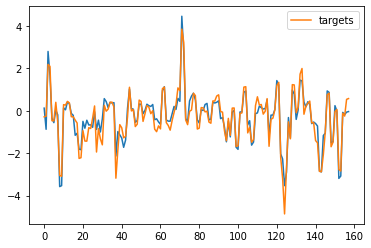

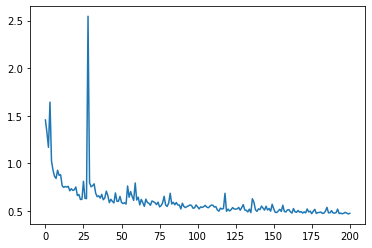

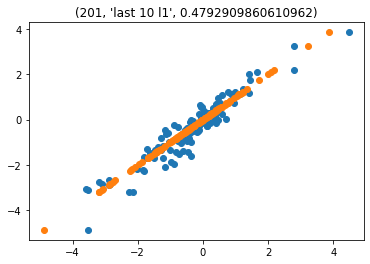

tensor(0.2937)
tensor(0.1525)
tensor(0.0757)


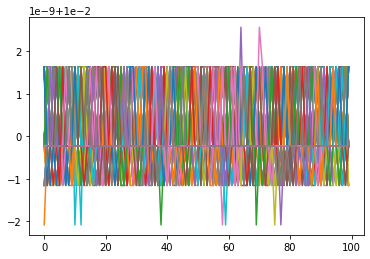

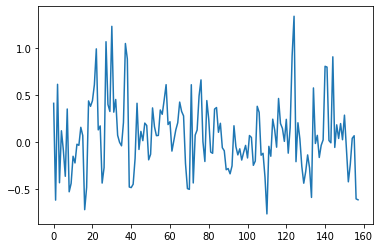

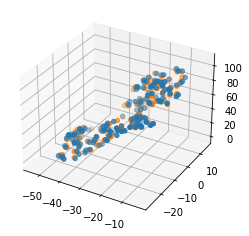

In [11]:

import torch
import numpy as np
import glob
p=glob.glob("../../../../data/all_checkpoints/benchmark*.pt")
#../../../data/all_checkpoints/benchmark_1049inputs_20250724_222627-noH-checkpoint_20250725_002142.pt
for c in p[-2:]:
    print(c)
    a=torch.load(c, map_location=torch.device('cpu'))
    m=a["mha"]
    e=a["net"]
    l1=a["lin"]
    #l2=a["lin2"]
    cc=a["convs"]
    #r=a["rbf"]
    op=a["optimizer"]
    sc=a["scheduler"]
    pe=a["model"]
    print(a["config"])
    
    import datetime, time
    #from architecture import *
    import torch
    import glob, math, time, datetime
    import numpy as np
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    from torch.cuda.amp import autocast, GradScaler
    from egnn_pytorch import EGNN_Network
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    import os

    from egnn_pytorch import EGNN_Network
    import torch
    import torch.nn as nn

    import math

    #EGNN
    class EGNNBlock(nn.Module):
        """todo: try to take head out here
        egnn_net --> layer norm --> ffn head"""
        def __init__(self, dim, depth,hidden_dim,dropout,
                    num_positions, num_tokens,
                    num_nearest_neighbors,
                    norm_coors):
            super().__init__()
            self.egnn = EGNN_Network(
                dim=dim, depth=depth, dropout=dropout,
                num_positions=num_positions,
                num_tokens=num_tokens,
                num_nearest_neighbors=num_nearest_neighbors,
                norm_coors=norm_coors
            )
            self.norm1 = nn.LayerNorm(dim)
            self.ffn = nn.Sequential(
                nn.Linear(dim, hidden_dim*dim),
                nn.PReLU(),# LU(),
                nn.Linear(hidden_dim*dim, dim),
            )
            self.norm2 = nn.LayerNorm(dim)
        def forward(self, z, x):
            (h_list, coords) = self.egnn(z, x)
            h = h_list # [B,N,dim]
            h2 = h
            h  = self.norm1(h + h2)
            h2 = self.ffn(h)
            h  = self.norm2(h + h2)
            return [h], coords

    class StackedEGNN(nn.Module):
        """TODO understand depth"""
        def __init__(self, dim, depth, hidden_dim, dropout,
                    num_positions, num_tokens,
                    num_nearest_neighbors,
                    norm_coors):
            super().__init__()
            self.blocks = nn.ModuleList([
                EGNNBlock(dim, depth, hidden_dim, dropout,
                        num_positions, num_tokens,
                        num_nearest_neighbors,
                        norm_coors)
                for _ in range(1)
            ])
        def forward(self, z, x):
            coords = x
            h_list = None
            for block in self.blocks:
                if h_list is None:
                    h_list, coords = block(z, x)
                else:
                    h_list, coords = block(z, coords)
            return h_list, coords

    # --- RBF with learnable cutoff ---
    class LearnableRBF(nn.Module):
        """TODO change cutout"""
        def __init__(self, num_basis=16, cutoff=10.0):
            super().__init__()
            #self.pairwise = torch.norm(x.unsqueeze(1) - x.unsqueeze(0), dim=-1)
            self.cutoff = nn.Parameter(torch.tensor(cutoff))
            self.mu     = nn.Parameter(torch.linspace(0.0, 1.0, num_basis))
            self.gamma  = nn.Parameter(torch.tensor(12.0))
        
        def pairwise_distances(self, dist):
            return torch.norm(dist.unsqueeze(1) - dist.unsqueeze(0), dim=-1)

        
        def forward(self, dist):
            # dist: [B,N,N]
            dist = self.pairwise_distances(dist)
            mu = self.mu * self.cutoff     # [K]
            d  = dist.unsqueeze(-1)        # [B,N,N,1]
            return torch.exp(-self.gamma * (d - mu)**2)


    #Attn. note encoding dropout of 0.03
    #TODO: SPECIFy max len and dropout.
    class PositionalEncoding(nn.Module):
        def __init__(self, embed_dim, max_len=1000, dropout=0.03):
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            pe = torch.zeros(max_len, embed_dim)
            pos = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
            div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float)
                            * (-math.log(10000.0) / embed_dim))
            pe[:, 0::2] = torch.sin(pos * div)
            cosp = torch.cos(pos * div)
            pe[:, 1::2] = cosp[:, : pe[:, 1::2].shape[1]]
            self.register_buffer('pe', pe.unsqueeze(1))
        def forward(self, x):
            return self.dropout(x + self.pe[: x.size(0)])

    # --- Transformer‐style AttentionBlock ---
    class AttentionBlock(nn.Module):
        def __init__(self, embed_dim, num_heads, hidden_dim):
            super().__init__()
            self.encoding = PositionalEncoding(embed_dim)
            self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
            self.norm1 = nn.LayerNorm(embed_dim)
            self.ffn   = nn.Sequential(
                nn.Linear(embed_dim, embed_dim * hidden_dim),
                nn.PReLU(),
                nn.Linear(embed_dim * hidden_dim, embed_dim),
            )
            self.norm2 = nn.LayerNorm(embed_dim)
            
        def forward(self, x, key_padding_mask=None):
            # x: [seq_len, batch, embed_dim]
            x = self.encoding(x)
            a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
            x    = self.norm1(x + a)
            f    = self.ffn(x)
            x    = self.norm2(x + f)
            return x,_

    class head(nn.Module):
        def __init__(self, embed_dim, num_heads, hidden_dim):
            super().__init__()
            self.encoding = PositionalEncoding(embed_dim)
            self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
            self.norm1 = nn.LayerNorm(embed_dim)
            self.ffn   = nn.Sequential(
                nn.Linear(embed_dim, embed_dim * hidden_dim),
                nn.PReLU(),
                nn.Linear(embed_dim * hidden_dim, embed_dim),
            )
            self.norm2 = nn.LayerNorm(embed_dim)
            
        def forward(self, x, key_padding_mask=None):
            # x: [seq_len, batch, embed_dim]
            x = self.encoding(x)
            a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
            x    = self.norm1(x + a)
            f    = self.ffn(x)
            x    = self.norm2(x + f)
            return x,_




    import datetime, time
    #from architecture import *
    import torch
    import glob, math, time, datetime
    import numpy as np
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    from torch.cuda.amp import autocast, GradScaler
    from egnn_pytorch import EGNN_Network
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    import os
    from egnn_pytorch import EGNN
    # 0) start timer
    t0 = time.time()
    N_NEIGHBORS = 100
    BATCH_SIZE  =  1         # not safe to increase
    PIN_MEMORY  = torch.cuda.is_available()
    # reproducibility + device
    torch.manual_seed(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # decide AMP only on GP0
    use_amp = (device.type == "cuda")
    if use_amp:
        scaler = GradScaler()
    else:
        class DummyCM:
            def __enter__(self): pass
            def __exit__(self, *args): pass
        autocast = DummyCM
        scaler   = None
    #{'runid': '20250714_013739', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs_test/*.npz', 1042), 'epochs': 50, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 102458}
    #.4045 val
    def init_model(dim,depth,hidden_dim,num_neighbors,dropout):
        
        def build_egnn(dim,depth,hidden_dim,num_neighbors, dropout):
            return StackedEGNN(
                dim=dim, depth=depth, hidden_dim=hidden_dim,
                dropout=dropout,
                num_positions=N_NEIGHBORS, num_tokens=98,
                num_nearest_neighbors=num_neighbors,
                norm_coors=True
            )
        net   = build_egnn(dim,depth,hidden_dim,num_neighbors,dropout).to(device)
        mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
        RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
        return net, mha, RBF
    #net,mha,RBF=init_model
    # 3) instantiate everything
    dim, basis = 6, 8 #scale to 3,16 at least # dim must be divisible by 2
    depth=2 #scale to 2, at least #TODO
    hidden_dim=4
    num_heads=(dim) 
    dropout=0.03
    cutoff=20.0
    num_neighbors=11



    runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


    from sklearn.neighbors import NearestNeighbors
    from torch.utils.data import Dataset, DataLoader
    import numpy as np, torch, glob

    class InMemoryHoodDataset(Dataset):
        """
        Loads *.npz files, constructs fixed-size neighbourhoods around each
        site (anchor) and stores the result entirely in RAM.

        For a protein with S sites the shapes are
            z   : (S, N_NEIGHBORS)      int32
            pos : (S, N_NEIGHBORS, 3)   float32
            y   : (S,)                  float32
        """
        def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
            super().__init__()
            self.data = []
            nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

            for p in paths:
                try:
                    dat = np.load(p, allow_pickle=True)
                    z_all   = dat["z"].astype(np.int32)        # (N,)
                    pos_all = dat["pos"].astype(np.float32)    # (N,3)
                    sites   = dat["sites"].astype(np.float32)  # (S,3)
                    y       = dat["pks"].astype(np.float32)    # (S,)
                    ids=dat["ids"]
                    print(p)
                    print(ids)
                    
                    #print(dat["ids"])
                    if len(sites) == 0:
                        continue  # skip empty entries

                    nbrs.fit(pos_all)
                    idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                    z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                    pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                    y        = torch.from_numpy(y)                     # (S,)

                    if pin_memory:
                        z_hood   = z_hood.pin_memory()
                        pos_hood = pos_hood.pin_memory()
                        y        = y.pin_memory()

                    self.data.append((z_hood, pos_hood, y))
                    print(y)
                except Exception as e:
                    print(f"skipping {p}: {e}")

        def __len__(self):             return len(self.data)
        def __getitem__(self, idx):    return self.data[idx]

    # ---------------------------------------------------------------------
    # 2) collate function  -------------------------------------------------
    # ---------------------------------------------------------------------
    def pad_collate(batch):
        B      = len(batch)
        S_max  = max(item[0].shape[0] for item in batch)   # longest protein

        # --- allocate on CPU (no device=...) ---------------
        zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 )
        pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32)
        ys   = torch.full  ((B, S_max), float("nan"),  dtype=torch.float32)
        mask = torch.zeros (B, S_max,               dtype=torch.bool)
        

        for b,(z,pos_b,y) in enumerate(batch):
            S = z.shape[0]
            zs [b, :S] = z
            pos[b, :S] = pos_b
            ys [b, :S] = y
            mask[b, :S] = True

        return zs, pos, ys, mask


    def count_params(model: torch.nn.Module, trainable_only: bool = True) -> int:
        """
        Returns the total number of (optionally trainable) parameters.
        """
        if trainable_only:
            return sum(p.numel() for p in model.parameters() if p.requires_grad)
        else:
            return sum(p.numel() for p in model.parameters())


    # ---------------------------------------------------------------------
    # 3) data loaders ------------------------------------------------------
    # ---------------------------------------------------------------------

    # 0) parameters you might want to expose at the top of the script
    # ---------------------------------------------------------------------

    # 3) data loaders ------------------------------------------------------
    # ---------------------------------------------------------------------
    np.random.seed(0)
    INPUTS_DIR="../../../../data/pkegnn_INS/inputs/*.npz"
    all_paths = glob.glob(INPUTS_DIR)
    #print(all_paths)
    #split=0.75
    #t=int(len(all_paths) *.75) - 1

    #v=int(len(all_paths) *.25)
    np.random.shuffle(all_paths)
    val_paths = all_paths[:2] #+# all_paths[5:15], all_paths[2:5]
    pdbs=["4ll7","4x0j"]#4b0y", "5mom", "2hoh", "6dy0", "1aka", "1tet"]
    p=all_paths[0]
    val_paths=[f"{p[:-8]}{pdb}.npz" for pdb in pdbs]
    #print(train_paths[0],val_paths[0])
    nconv=nn.Conv1d(N_NEIGHBORS,1,dim).to(device)
    nconv.load_state_dict(cc[1])
    conv=nn.Conv1d(1, 1, 7, padding=3).to(device)
    conv.load_state_dict(cc[0])
    #train_ds = InMemoryHoodDataset(train_paths)
    val_ds   = InMemoryHoodDataset(val_paths)

    #train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
    #                          shuffle=True,  collate_fn=pad_collate,
    #                          num_workers=0, pin_memory=PIN_MEMORY)
    val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                            shuffle=False, collate_fn=pad_collate,
                            num_workers=0, pin_memory=PIN_MEMORY)


    # ---------------------------------------------------------------------
    # 4) model pieces ------------------------------------------------------
    # ---------------------------------------------------------------------
    egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                        dropout=dropout, num_positions=1000, num_tokens=118,
                        num_nearest_neighbors=num_neighbors,
                        norm_coors=True).to(device)
    egnn_net.load_state_dict(e)

    #rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
    #rbf_layer.load_state_dict(r)
    #rbf_layer.loa
    mha_layer = AttentionBlock(embed_dim=dim,
                            num_heads=num_heads,
                            hidden_dim=hidden_dim).to(device)
    mha_layer.load_state_dict(m)
    pred_head = nn.Linear(1, 1).to(device)
    pred_head.load_state_dict(l1)
    #pred_head2 = nn.Linear(1, 1).to(device).load_state_dict(l2)

    #protein_egnn=EGNN(dim=1,update_coors=False).load_state_dict(pe)
    protein_egnn=EGNN(dim=1,update_coors=True, norm_coors=True, norm_feats=True, fourier_features=6, valid_radius=8)
    protein_egnn.load_state_dict(pe)
    criterion = nn.L1Loss()



    optimizer = torch.optim.AdamW(
        list(egnn_net.parameters()) +
        #list(rbf_layer.parameters()) +
        list(mha_layer.parameters()) +
        list(conv.parameters()) +
        list(nconv.parameters()) +
        list(pred_head.parameters()) +
        list(protein_egnn.parameters()),
        lr=5e-3
    )
    optimizer.load_state_dict(op)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
    scheduler.load_state_dict(sc)

    modell=[egnn_net, protein_egnn, nconv,mha_layer,pred_head,conv]
    #scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
    epochs = 1 # or whatever you like
    total_all    = count_params(torch.nn.ModuleList(
                        modell))

    #print(f"Atom-level EGNN      : {total_egnn:,}")
    #print(f"Residue-level EGNN   : {total_res:,}")
    #print(f"Prediction head      : {total_head:,}")
    print(f"Whole model          : {total_all:,}")

    config={"runid": runid,
            "num_nbrs": N_NEIGHBORS,
            "num_nbrs_egnn": num_neighbors,
            "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
            "dataset": (INPUTS_DIR,len(val_ds)),
            "epochs": epochs,
            "dim": dim,
            "depth": depth,
            "basis": basis,
            "hidden_dim":hidden_dim,
            "num_heads":num_heads,
            "dropout": [dropout, 0.03], #egnn p.enc. 
            #"rbf cutoff": cutoff,
            "loss": criterion,
            "params":total_all}
            #"architect":str(modell).encode()}

    print(config)
    # ---------------------------------------------------------------------
    # 5) forward for a *compressed* batch (R residues, N neighbours)
    # ---------------------------------------------------------------------
    # ---------------------------------------------------------------------
    # 5) single-path forward – no shape guessing, no branching
    # ---------------------------------------------------------------------
    def forward_residues(z_r, x_r):
        """
        z_r : (R, N)       int32   – atomic numbers for R residues
        x_r : (R, N, 3)    float32 – coordinates
        returns (R, dim + basis)   – per-residue embeddings
        """
        # ---------- EGNN ----------
        h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
        h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

        # ---------- RBF on *input* coords (already (R,N,3)) ----------
        #d   = torch.cdist(x_r, x_r)            # (R, N, N)
        #rbf = rbf_layer(coords)                     # (R, N, N, basis)
        

        # ---------- concat & attention ----------
        h0  = h.transpose(1, 2)                # (R, dim,   N)
        #r0  = rbf.mean(dim=0).transpose(1, 2)        # (R, basis, N)
        #tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)
        tok=h0
        tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE) #TODO suppress _
        tokk=nconv(tok.to(device).permute(1,0,2)).to(device)
        #torch.shuff
        #tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
        return tokk,     coords.mean(dim=1).unsqueeze(0), _, tok                              # (R, dim + basis)
                                            # (R, dim+basis)

    # ---------------------------------------------------------------------
    # 6) training / validation loop ---------------------------------------
    # ---------------------------------------------------------------------
    tloss, vloss = [], []
    for epoch in range(epochs):

        
        # ======== VALID ========
        egnn_net.eval()
        #rbf_layer.eval(); 
        mha_layer.eval(); protein_egnn.eval(); conv.eval(); nconv.eval();pred_head.eval(); #pred_head2.eval(); 
        vl_losses = []
        
        with torch.no_grad():
            for z, x, y, mask in val_loader:
                valid   = mask.view(-1)
                z_res   = z.view(-1, z.size(2))[valid].to(device)
                x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
                y_res   = y.view(-1)[valid].to(device)

                    #model
                feats, centroids, _ , ou = forward_residues(z_res, x_res)         # (R, C)
            
                preds = pred_head(feats.to(device))    
                t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
                centroids = centroids.to(device)  # (1, R, 3) on GPU
                
                protein_egnn = protein_egnn.to(device)             # make sure weights are there
                preds=preds[torch.randperm(len(preds))]
                preds, cents = protein_egnn(t, centroids)
                preds=preds.permute(1,2,0)
                #preds=preds[torch.randperm(len(preds))]
                #preds = pred_head2(preds.to(device))
                with autocast():
                    preds=conv(preds).to(device)

                    loss  = criterion(preds.flatten(), y_res)
                from matplotlib import pyplot as plt
                #plt.plot(feats.flatten().detach().numpy())
                #plt.show()
                #plt.plot(preds.flatten().detach().numpy())

                #plt.plot(y_res.flatten().detach().numpy())
                #plt.show()
                plt.plot(preds.flatten().detach().numpy())
                #plt.show()

                plt.plot(y_res.flatten().detach().numpy(),label="targets")
                plt.legend()
                plt.show()
                plt.plot(a["val_history"])
                plt.show()
                #plt.plot(np.array(a["val_history"]))
                #plt.show()
                plt.plot(preds.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
                plt.plot(y_res.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
                plt.title((a["epoch"],"last 10 l1",np.mean(a["val_history"][-10:])))
                plt.show()
                print(loss)
                print(nn.MSELoss()(preds.flatten(), y_res))
                print(nn.HuberLoss()(preds.flatten(), y_res))
                for i in _.mean(dim=2):
                    plt.plot(i)
                plt.show()
                plt.plot(preds.flatten() - y_res)
                plt.show()
                
                #avg = _.mean(dim=-1).cpu().numpy()  # shape (45,100)
                #plt.imshow(avg, cmap='viridis', aspect='auto')

                cent=x_res.mean(dim=1)
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                ch=centroids[0]
                ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
                ax.scatter(ch[:, 0], ch[:, 1], ch[:, 2], label="Updated")
                plt.show()
                #x=np.array(range(0,len(a["val_history"])))
                #print(x.shape)
                #plt.plot(np.array(a["val_history"]))
                #plt.show()
                #fig = plt.figure()
                #ax = fig.add_subplot(111, projection='3d')
                #ax.scatter(ch[:, 0], ch[:, 1], ch[:, 2], label="Updated")
                


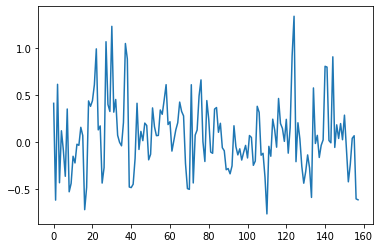

In [10]:
plt.plot(preds.flatten() - y_res)
#plt.xlim(50,70)

In [8]:
torch.max(z_res)

tensor(16, dtype=torch.int32)